In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [2]:
#加载数据
def load_and_preprocess():
    df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None)
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 
                'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 
                'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    df_train = df_train.dropna(axis=1, how='all')
    df_train.columns = col_list
    sensor_cols = [col for col in df_train.columns if col.startswith( 'sm_')]
    df_train[sensor_cols] = minmax_scale(df_train[sensor_cols])
    
    return df_train

In [3]:
# 计算实时RUL
def calculate_rul(df):
    max_cycle = df.groupby('unit')['time'].max().reset_index()
    max_cycle.columns = ['unit', 'max_time']
    df = df.merge(max_cycle, on='unit', how='left')
    df['RUL'] = df['max_time'] - df['time']
    return df

In [4]:
# 计算皮尔逊相关系数
def compute_global_correlations(df):
    # 自动识别传感器列
    sensor_cols = [col for col in df.columns if col.startswith('sm_')]
    # 计算相关性
    corr_matrix = df[sensor_cols + ['RUL']].corr(method='pearson')
    correlations = corr_matrix['RUL'].drop('RUL')
    # 按绝对值排序
    return correlations.reindex(correlations.abs().sort_values(ascending=False).index)

In [5]:
# 主流程
df_train = load_and_preprocess()
df_train = calculate_rul(df_train)
# 计算全局相关性
correlations = compute_global_correlations(df_train)

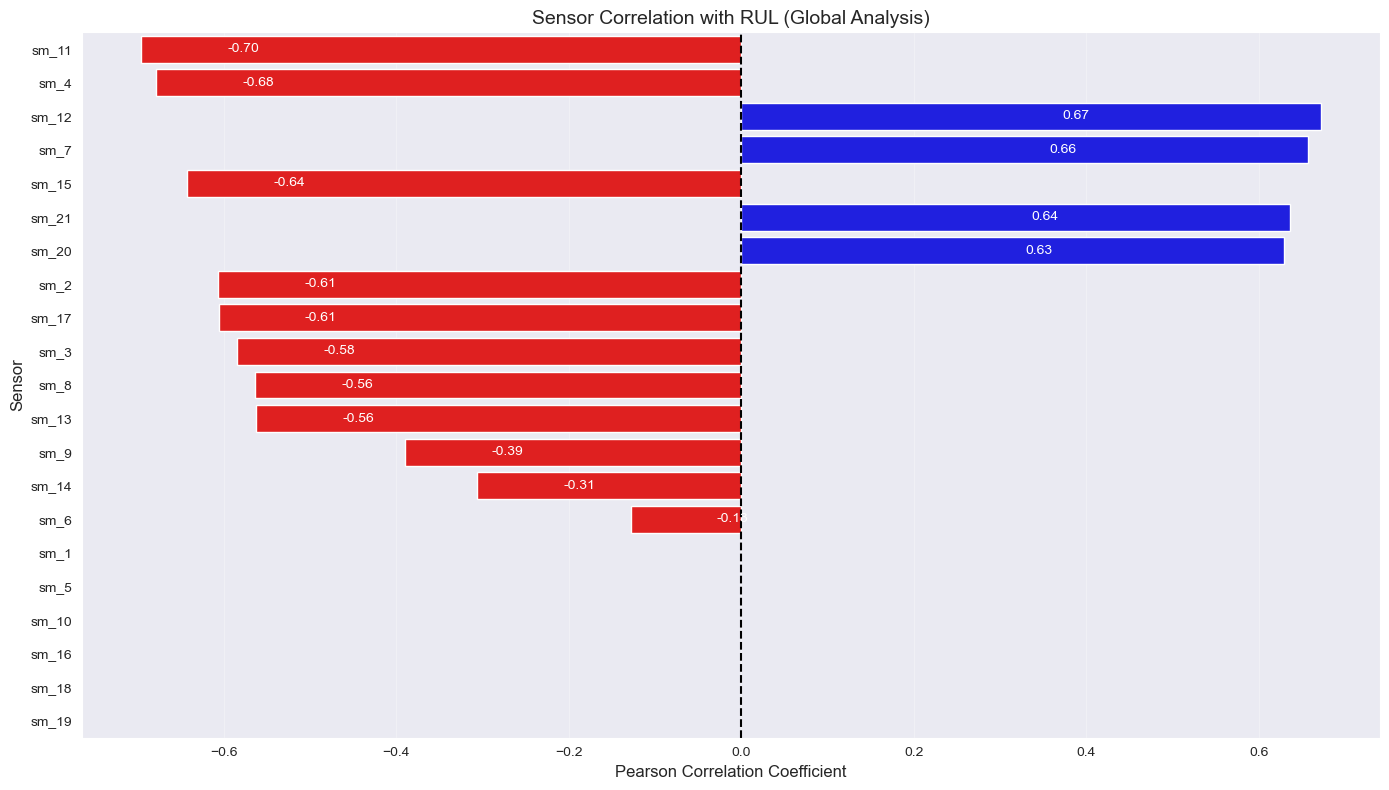

In [9]:
# 可视化部分
plt.figure(figsize=(14, 8))

# 创建正负标签和颜色映射
df_plot = pd.DataFrame({
    'sensor': correlations.index,
    'corr': correlations.values,
    'sign': np.where(correlations.values < 0, 'Negative', 'Positive')
}).sort_values(by='corr', key=abs, ascending=False)

# 使用hue参数配合palette
sns.barplot(
    x='corr', 
    y='sensor', 
    hue='sign',
    data=df_plot,
    palette={'Negative': 'red', 'Positive': 'blue'},
    dodge=False,  # 禁用分组
    legend=False
)

plt.title('Sensor Correlation with RUL (Global Analysis)', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Sensor', fontsize=12)
plt.axvline(0, color='k', linestyle='--')
plt.grid(axis='x', alpha=0.3)

# 添加数值标签
for index, row in df_plot.reset_index(drop=True).iterrows():
    color = 'white'
    ha = 'right' if row['corr'] > 0 else 'left'
    offset = -0.3 if row['corr'] > 0 else 0.1 
    plt.text(
        row['corr'] + offset, 
        index, 
        f"{row['corr']:.2f}", 
        va='center', 
        color=color, 
        fontsize=10
    )

plt.tight_layout()
plt.show()